# Importações

In [1]:
import os
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import xml.etree.ElementTree as xet
from glob import glob
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import random
import time

# Tratando Dataset

In [8]:
!curl -L -o /tmp/tcc_alpd/archive.tar.gz "https://www.dropbox.com/scl/fi/khnnv0x8pcpbzlgfevqac/archive.tar.gz?rlkey=55w3pkxp02szjpqw22df7hmn8&dl=0"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   256    0   256    0     0    242      0 --:--:--  0:00:01 --:--:--   242
100   491    0   491    0     0    211      0 --:--:--  0:00:02 --:--:--   960
100  202M  100  202M    0     0  13.2M      0  0:00:15  0:00:15 --:--:-- 17.0M


In [9]:
!tar xfv /tmp/tcc_alpd/archive.tar.gz -C /tmp/tcc_alpd/

archive/
archive/.DS_Store
archive/images/
archive/annotations/
archive/annotations/Cars213.xml
archive/annotations/Cars207.xml
archive/annotations/Cars398.xml
archive/annotations/Cars367.xml
archive/annotations/Cars401.xml
archive/annotations/Cars415.xml
archive/annotations/Cars373.xml
archive/annotations/Cars429.xml
archive/annotations/Cars47.xml
archive/annotations/Cars53.xml
archive/annotations/Cars165.xml
archive/annotations/Cars171.xml
archive/annotations/Cars159.xml
archive/annotations/Cars84.xml
archive/annotations/Cars90.xml
archive/annotations/Cars91.xml
archive/annotations/Cars85.xml
archive/annotations/Cars158.xml
archive/annotations/Cars170.xml
archive/annotations/Cars164.xml
archive/annotations/Cars52.xml
archive/annotations/Cars46.xml
archive/annotations/Cars428.xml
archive/annotations/Cars414.xml
archive/annotations/Cars372.xml
archive/annotations/Cars366.xml
archive/annotations/Cars400.xml
archive/annotations/Cars399.xml
archive/annotations/Cars206.xml
archive/annotati

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3354984463667460846
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10895949824
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6677616158508514348
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


2024-04-25 16:44:51.929296: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-25 16:44:51.997031: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-25 16:44:52.993370: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-25 16:44:52.994175: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [3]:
IMAGE_PATH="/tmp/tcc_alpd/archive/images/"
ANNOTATIONS_PATH = "/tmp/tcc_alpd/archive/annotations/"

In [4]:
def generate_dataframe_from_xml_annotations(annotations, images):
    path = glob(annotations)
    labels_dict = dict(image=[], xmin=[], xmax=[], ymin=[], ymax=[])

    for filename in path:
        info = xet.parse(filename)
        root = info.getroot()
        member_object = root.find('object')
        labels_info = member_object.find('bndbox')
        xmin = int(labels_info.find('xmin').text)
        xmax = int(labels_info.find('xmax').text)
        ymin = int(labels_info.find('ymin').text)
        ymax = int(labels_info.find('ymax').text)

        image_name = os.path.basename(filename)
        image_name = image_name.replace(".xml", ".png")

        labels_dict['image'].append(image_name)

        img = cv2.imread(os.path.join(images, image_name))
        altura_original, largura_original, _ = img.shape

        # Ajustar os valores da bbox para a nova resolução (64x64)
        # Fazer os cálculos de redimensionamento
        # Por exemplo, se a nova resolução é 64x64 e a resolução original é 256x256:
        # A nova coordenada = (coordenada original * nova largura ou altura) / largura ou altura original
        xmin_new = (xmin * 64) / largura_original
        xmax_new = (xmax * 64) / largura_original
        ymin_new = (ymin * 64) / altura_original
        ymax_new = (ymax * 64) / altura_original

        labels_dict['xmin'].append(xmin_new)
        labels_dict['xmax'].append(xmax_new)
        labels_dict['ymin'].append(ymin_new)
        labels_dict['ymax'].append(ymax_new)

    df = pd.DataFrame(labels_dict)
    return df

In [10]:
df = generate_dataframe_from_xml_annotations(ANNOTATIONS_PATH+'*.xml', IMAGE_PATH)
df

,image,xmin,xmax,ymin,ymax
0,Cars232.png,28.000000,36.480000,37.120000,42.880000
1,Cars289.png,26.080000,43.360000,29.185668,36.065147
2,Cars118.png,20.586667,42.026667,28.160000,37.034667
3,Cars49.png,42.880000,50.240000,43.256917,48.063241
4,Cars241.png,20.160000,38.560000,34.037453,47.700375
...,...,...,...,...,...
428,Cars210.png,8.640000,50.400000,21.654135,38.255639
429,Cars70.png,28.640000,34.080000,32.566372,37.663717
430,Cars329.png,26.560000,35.840000,35.639216,44.172549
431,Cars192.png,21.399381,41.808050,42.290749,48.775330


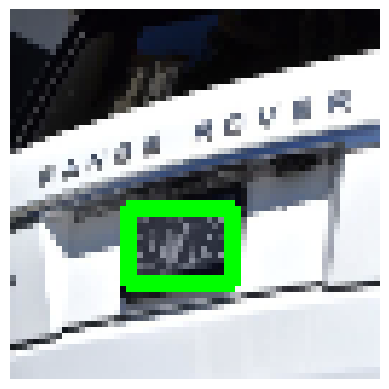

In [11]:
import cv2
import matplotlib.pyplot as plt

def plot_image_with_bbox_from_df(df, index, images_directory):
    row = df.iloc[index]
    image_name = row['image']
    xmin = row['xmin']
    xmax = row['xmax']
    ymin = row['ymin']
    ymax = row['ymax']

    image_path = os.path.join(images_directory, image_name)

    img = cv2.imread(image_path)

    img_resized = cv2.resize(img, (64, 64))

    cv2.rectangle(img_resized, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 2)

    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

plot_image_with_bbox_from_df(df, 4, IMAGE_PATH)

In [12]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

print("Tamanho do DataFrame de treinamento:", len(train_df))
print("Tamanho do DataFrame de teste:", len(test_df))

Tamanho do DataFrame de treinamento: 346
Tamanho do DataFrame de teste: 87


In [13]:
test_df

,image,xmin,xmax,ymin,ymax
425,Cars245.png,14.560000,26.240000,26.367041,33.078652
75,Cars206.png,15.200000,26.240000,39.466667,43.946667
181,Cars414.png,43.040000,49.440000,49.378277,54.651685
30,Cars367.png,31.857778,54.328889,34.461538,47.518395
364,Cars399.png,16.960000,49.440000,17.635556,45.795556
...,...,...,...,...,...
57,Cars5.png,36.160000,38.720000,47.294915,52.067797
124,Cars90.png,12.320000,16.160000,43.520000,48.000000
24,Cars171.png,30.720000,38.720000,34.865672,39.880597
17,Cars47.png,0.960000,7.680000,30.506667,34.346667


In [14]:
def make_dataset(row):
    img = tf.io.read_file(IMAGE_PATH + row)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [64, 64])
    return img

train = list(map(make_dataset, train_df.image.values))
test = list(map(make_dataset, test_df.image.values))

2024-04-25 16:47:46.086586: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-25 16:47:46.086851: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-25 16:47:46.087044: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-25 16:47:46.087529: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-25 16:47:46.087729: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [15]:
train_ds = tf.data.Dataset.from_tensor_slices((train, (train_df.xmin.values, train_df.ymin.values, train_df.xmax.values, train_df.ymax.values)))
test_ds = tf.data.Dataset.from_tensor_slices((test, (test_df.xmin.values, test_df.ymin.values, test_df.xmax.values, test_df.ymax.values)))

In [16]:
rescaling = layers.Rescaling(scale=1./127.5, offset=-1)
resizing = layers.Resizing(64, 64)

In [17]:
train_ds = train_ds.map(lambda x, y: (resizing(x), y), num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (resizing(x), y), num_parallel_calls=tf.data.AUTOTUNE)

In [18]:
train_ds = train_ds.batch(128).prefetch(tf.data.AUTOTUNE)

In [19]:
test_ds = test_ds.batch(1).prefetch(tf.data.AUTOTUNE)

# Treinando Modelo

In [20]:
img_input = layers.Input(shape=(64, 64, 3))

x = img_input
x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
x = layers.AveragePooling2D()(x)
x = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.AveragePooling2D()(x)
x = layers.Conv2D(512, (3, 3), padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.AveragePooling2D()(x)
x = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.AveragePooling2D()(x)
x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.AveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation="relu")(x)
final = layers.Dropout(0.2)(x)

a = layers.Dense(1, name="a")(final)
b = layers.Dense(1, name="b")(final)
c = layers.Dense(1, name="c")(final)
d = layers.Dense(1, name="d")(final)

model = tf.keras.Model(img_input, [a, b, c, d])

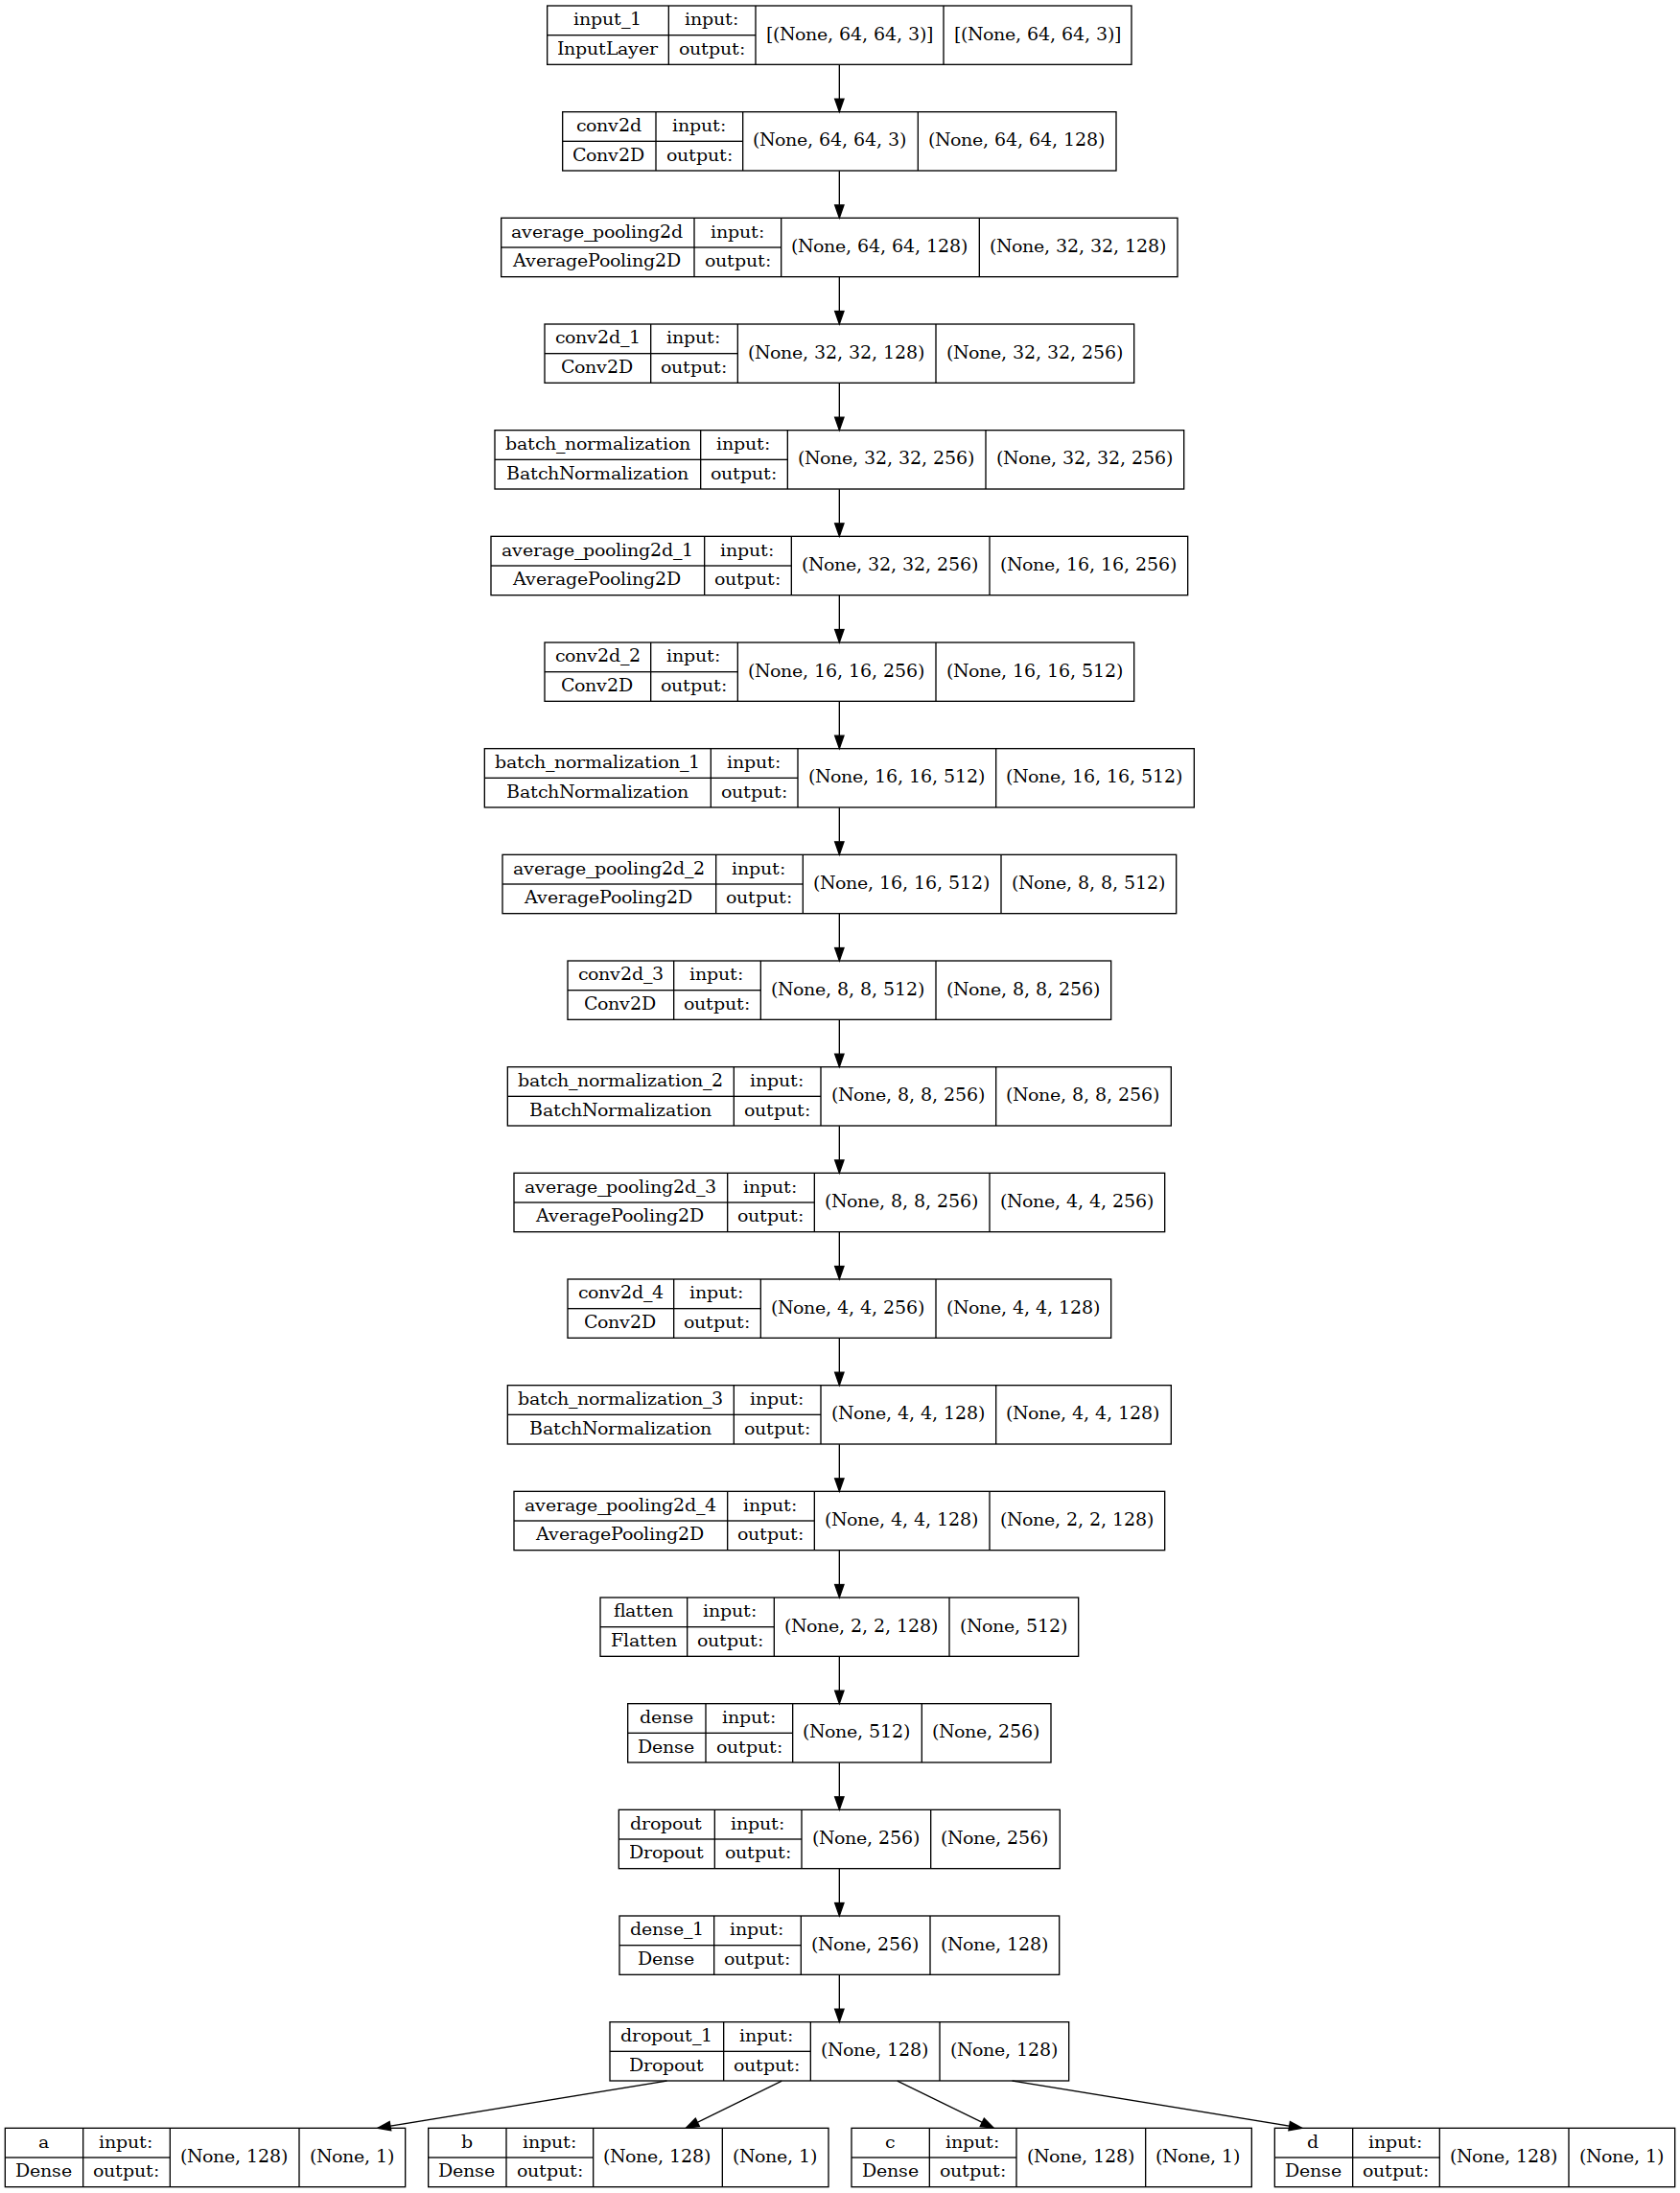

In [21]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [22]:
model.compile(optimizer="adam", loss={
    "a": tf.keras.losses.MeanAbsoluteError(),
    "b": tf.keras.losses.MeanAbsoluteError(),
    "c": tf.keras.losses.MeanAbsoluteError(),
    "d": tf.keras.losses.MeanAbsoluteError()
})

In [23]:
model.fit(train_ds, epochs=500)

Epoch 1/500


2024-04-25 16:47:55.101453: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8907
2024-04-25 16:47:59.233714: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3/3 [==============================] - 10s 603ms/step - loss: 140.7152 - a_loss: 23.5463 - b_loss: 34.1604 - c_loss: 40.1306 - d_loss: 42.8778
Epoch 2/500
3/3 [==============================] - 0s 50ms/step - loss: 115.2910 - a_loss: 17.8686 - b_loss: 27.2701 - c_loss: 33.8929 - d_loss: 36.2594
Epoch 3/500
3/3 [==============================] - 0s 50ms/step - loss: 72.8847 - a_loss: 10.9782 - b_loss: 15.6906 - c_loss: 23.0345 - d_loss: 23.1814
Epoch 4/500
3/3 [==============================] - 0s 50ms/step - loss: 44.1485 - a_loss: 13.2058 - b_loss: 9.5796 - c_loss: 11.6454 - d_loss: 9.7178
Epoch 5/500
3/3 [==============================] - 0s 51ms/step - loss: 39.9499 - a_loss: 11.8475 - b_loss: 8.7276 - c_loss: 11.1940 - d_loss: 8.1807
Epoch 6/500
3/3 [==============================] - 0s 51ms/step - loss: 36.3057 - a_loss: 9.6700 - b_loss: 8.5806 - c_loss: 10.0873 - d_loss: 7.9677
Epoch 7/500
3/3 [==============================] - 0s 50ms/step - loss: 35.7195 - a_loss: 10.0490 - b_l

In [24]:
model.save('./scratch_lpd.h5')

# Validando Modelo

In [25]:
def produce_bounding_box(image):
    test_img = tf.io.read_file(image)
    test_img = tf.image.decode_jpeg(test_img, channels=3)
    test_img = tf.image.resize(test_img, (64, 64))
    test_img = tf.expand_dims(test_img, 0)

    outputs = model(test_img)

    width, height = tf.shape(test_img)[2], tf.shape(test_img)[1]
    xmin = int(outputs[0][0][0].numpy())
    ymin = int(outputs[1][0][0].numpy())
    xmax = int(outputs[2][0][0].numpy())
    ymax = int(outputs[3][0][0].numpy())

    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    bounded = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 4)

    return bounded

In [26]:
outputs = model.predict(test_ds)


In [27]:
predictions = []

for i in range(len(test_df)):
    image_name = test_df.iloc[i]['image']

    image_path = IMAGE_PATH + image_name

    test_img = tf.io.read_file(image_path)
    test_img = tf.image.decode_jpeg(test_img, channels=3)
    test_img = tf.image.resize(test_img, (64, 64))
    test_img = tf.expand_dims(test_img, 0)

    outputs = model(test_img)

    xmin = int(outputs[0][0][0].numpy())
    ymin = int(outputs[1][0][0].numpy())
    xmax = int(outputs[2][0][0].numpy())
    ymax = int(outputs[3][0][0].numpy())

    predictions.append({'image': image_name,
                        'xmin': xmin,
                        'ymin': ymin,
                        'xmax': xmax,
                        'ymax': ymax})

predictions_df = pd.DataFrame(predictions)

In [28]:
predictions_df

,image,xmin,ymin,xmax,ymax
0,Cars245.png,15,26,27,35
1,Cars206.png,12,44,25,51
2,Cars414.png,34,46,40,50
3,Cars367.png,34,35,53,46
4,Cars399.png,15,17,46,46
...,...,...,...,...,...
82,Cars5.png,24,28,31,35
83,Cars90.png,26,29,34,35
84,Cars171.png,30,34,38,40
85,Cars47.png,56,24,64,31


In [29]:
true_positive = false_positive = false_negative = 0
iou_threshold = 0.5

for _, pred_row in predictions_df.iterrows():
    test_row = test_df[test_df['image'] == pred_row['image']]

    if len(test_row) > 0:
        intersection_xmin = max(pred_row['xmin'], test_row.iloc[0]['xmin'])
        intersection_ymin = max(pred_row['ymin'], test_row.iloc[0]['ymin'])
        intersection_xmax = min(pred_row['xmax'], test_row.iloc[0]['xmax'])
        intersection_ymax = min(pred_row['ymax'], test_row.iloc[0]['ymax'])

        intersection_area = max(0, intersection_xmax - intersection_xmin) * max(0, intersection_ymax - intersection_ymin)
        pred_area = (pred_row['xmax'] - pred_row['xmin']) * (pred_row['ymax'] - pred_row['ymin'])
        test_area = (test_row.iloc[0]['xmax'] - test_row.iloc[0]['xmin']) * (test_row.iloc[0]['ymax'] - test_row.iloc[0]['ymin'])
        union_area = pred_area + test_area - intersection_area

        iou = intersection_area / union_area

        if iou >= iou_threshold:
            true_positive += 1
        else:
            false_positive += 1
    else:
        false_positive += 1

false_negative = len(test_df) - true_positive

precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)

print("Precisão:", precision)
print("Recall:", recall)

Precisão: 0.41379310344827586
Recall: 0.41379310344827586


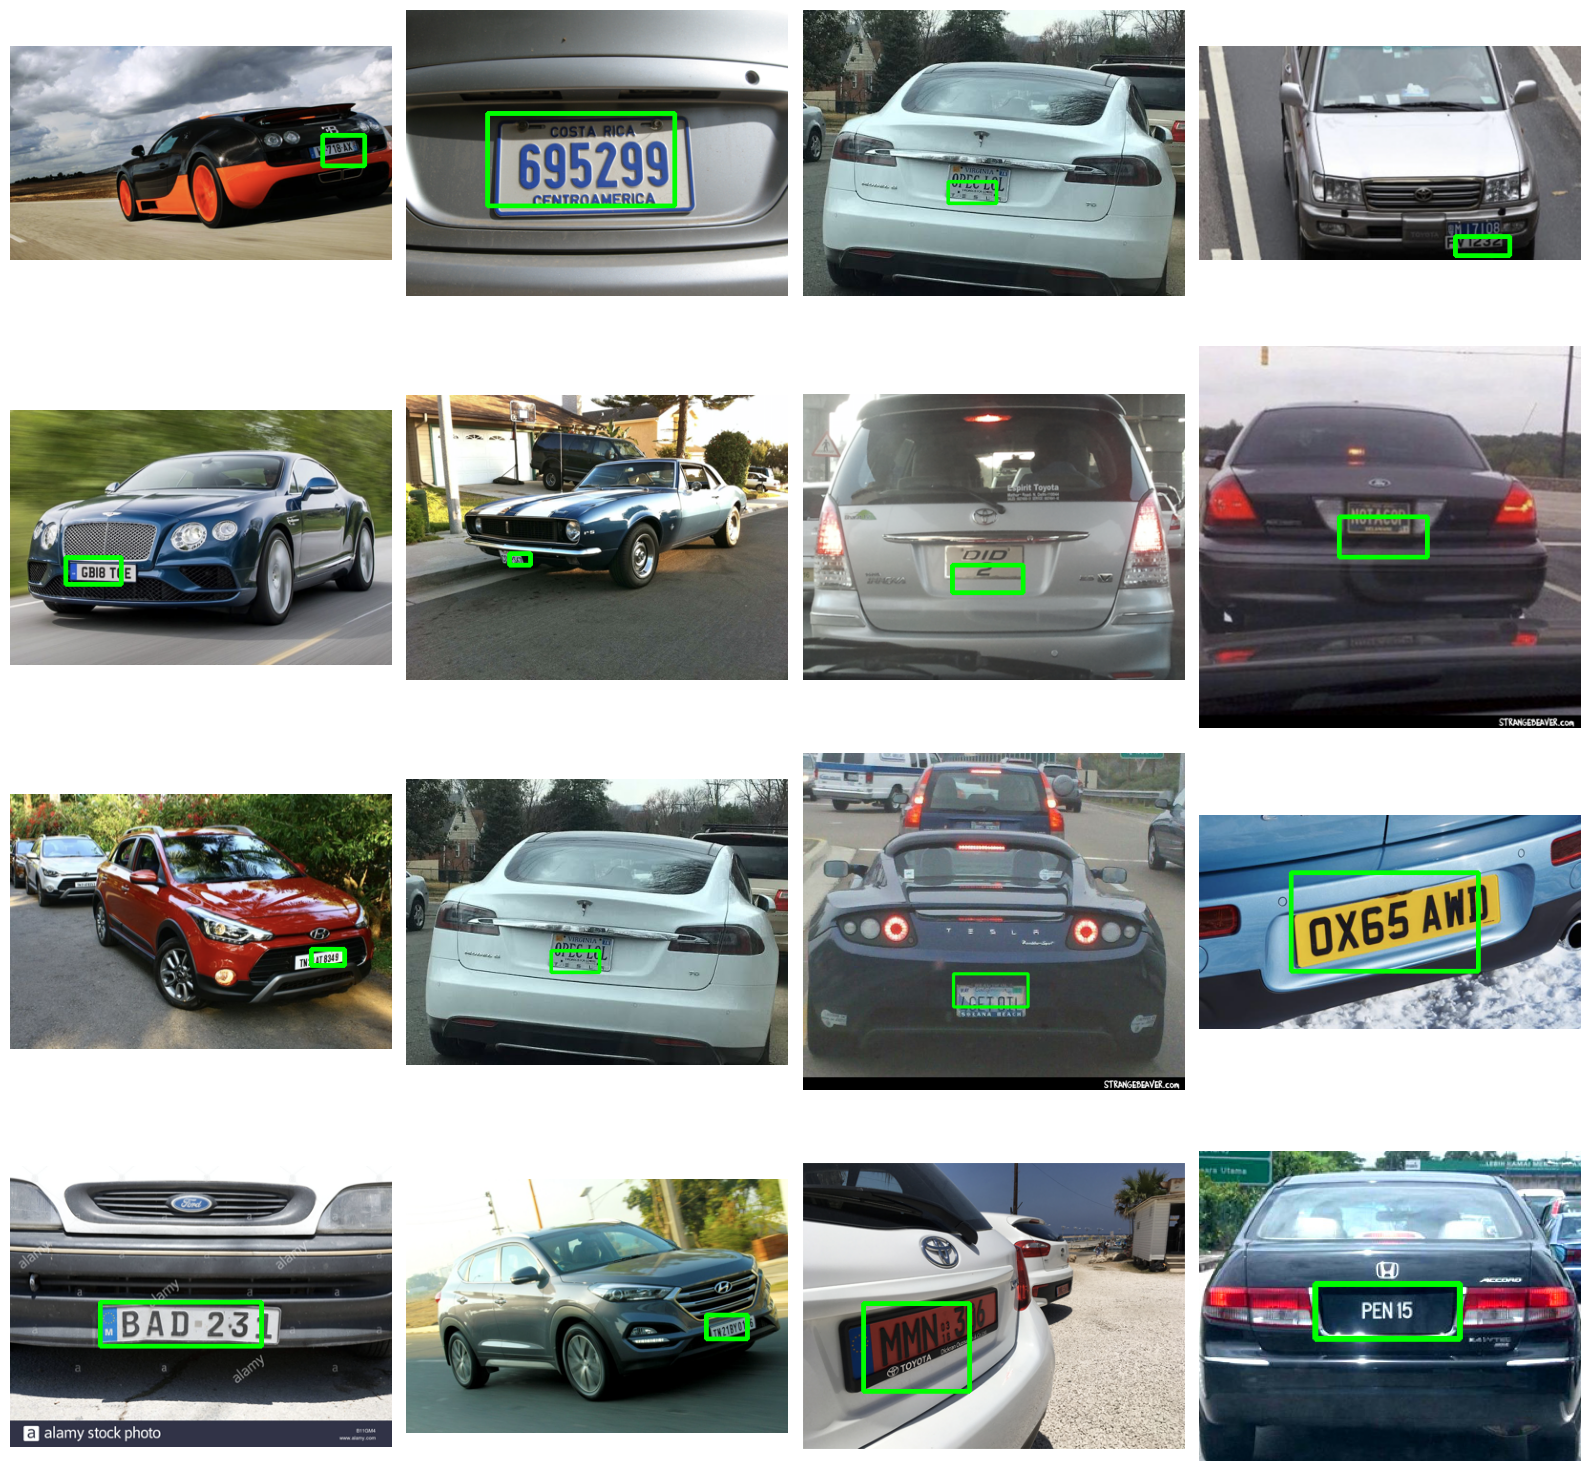

In [32]:
def produce_bounding_box(directory, model):
    images = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.png')]

    random_images = random.sample(images, 16)

    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    axes = axes.ravel()

    for ax, image in zip(axes, random_images):
        img = cv2.imread(image)
        img_orig = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        height_orig, width_orig, _ = img_orig.shape

        test_img = tf.io.read_file(image)
        test_img = tf.image.decode_png(test_img, channels=3)
        test_img_resized = tf.image.resize(test_img, (64, 64))

        test_img_resized = tf.expand_dims(test_img_resized, 0)
        outputs = model(test_img_resized)

        xmin = int(outputs[0][0][0].numpy() * (width_orig / 64))
        ymin = int(outputs[1][0][0].numpy() * (height_orig / 64))
        xmax = int(outputs[2][0][0].numpy() * (width_orig / 64))
        ymax = int(outputs[3][0][0].numpy() * (height_orig / 64))

        bounded = cv2.rectangle(img_orig, (xmin, ymin), (xmax, ymax), (0, 255, 0), 4)

        ax.imshow(bounded)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

produce_bounding_box(IMAGE_PATH, model)

In [31]:
def predict_time(image_paths, num_images=100):
    random_images = random.sample(image_paths, num_images)

    start_time = time.time()

    for image_path in random_images:
        test_img = tf.io.read_file(image_path)
        test_img = tf.image.decode_jpeg(test_img, channels=3)
        test_img = tf.image.resize(test_img, (64, 64))
        test_img = tf.expand_dims(test_img, 0)

        outputs = model(test_img)

    end_time = time.time()

    elapsed_time = end_time - start_time
    print("Tempo total de predição para 100 imagens aleatórias: {:.2f} segundos".format(elapsed_time))

image_paths = [os.path.join(IMAGE_PATH, filename) for filename in os.listdir(IMAGE_PATH)]
predict_time(image_paths)

Tempo total de predição para 100 imagens aleatórias: 1.47 segundos
